*DistilBERT model on Balanced data.*


This notebook presents training the DistilBERT on a balanced dataset.To ensure uniformity, as this is a comparative analysis study,the same data preprocessing and preparation techniques and the same hyperparmeters settings like for BERT are used.

In [ ]:
##importing necesaary libraries
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification, create_optimizer
import tensorflow as tf
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

# Download stopwords if not already downloaded
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Loading data
data = pd.read_csv('Service_tickets.csv')
data.shape

(47837, 2)

In [ ]:
# checking the count of the frequency of the Classes
data['Topic_group'].value_counts()

,count
Topic_group,
Hardware,13617
HR Support,10915
Access,7125
Miscellaneous,7060
Storage,2777
Purchase,2464
Internal Project,2119
Administrative rights,1760



**Data Cleaning and Encoding the Category Labels**

This step involves removing  non-alphabetic characters, Converting text to lowercase and removing stop words.
Also the target variable , topic groups is encoded  into numeric format for prepration for the models.

In [ ]:
# Function to clean text
def clean_text(text):
    text = text.lower()
    text = re.sub('[^a-zA-Z\s]', '', text)
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text


data['Cleaned_Document'] = data['Document'].apply(clean_text)

#Defining DataFrame to have columns needed
data = data[['Cleaned_Document', 'Topic_group']]

# Encoding category labels using category codes
data["encoded_label"] = data["Topic_group"].astype('category').cat.codes




**Balancing the Dataset Through Undersampling and Oversampling .**

A target size 5,000 is set basing on the median, and undersampling is done for classes that  exceed 5,000 by randomly selecting and removing the samples until the target is reached
For classes with less than 5,000, oversampling is done by randomly duplicating samples until there are 5,000 thus achieving a balanced dataset.

In [ ]:
# Balancing the dataset
target_size = 5000
balanced_data = pd.DataFrame(columns=data.columns)
for topic_group in data['Topic_group'].unique():
    topic_group_data = data[data['Topic_group'] == topic_group]
    if len(topic_group_data) > target_size:
        # Undersample
        undersampled_data = resample(topic_group_data, replace=False, n_samples=target_size, random_state=42)
        balanced_data = pd.concat([balanced_data, undersampled_data])
    else:
        # Oversample
        oversampled_data = resample(topic_group_data, replace=True, n_samples=target_size, random_state=42)
        balanced_data = pd.concat([balanced_data, oversampled_data])
balanced_data.reset_index(drop=True, inplace=True)

# Printing class distribution after balancing
print("Class distribution after balancing:")
print(balanced_data['Topic_group'].value_counts())

Class distribution after balancing:
Topic_group
Hardware                 5000
Access                   5000
Miscellaneous            5000
HR Support               5000
Purchase                 5000
Administrative rights    5000
Storage                  5000
Internal Project         5000
Name: count, dtype: int64


**Data Preparation for DistilBERT: Splitting, Tokenization, and Encoding**

The Balanced Data is split into Training and Test Sets using stratified spliting to ensure the class  distribution in the training and test sets represents the overall class distribution in the balanced dataset.A further Split of the train data into train and validation Sets for validationg the model and for hyperparameter tuning during training.The test split is reserved for model evaluation after training.

DistilBertTokenizer is used  for tokenizing the text data by converting them into tokenized sequences, and theyre truncated if longer than 512 tokens set limit,
Padding is done for texts shorter than 512tokens to have equal lenght for the sequences.

Converted the train,test and validation sets labels and the tokenized encodings to Numpy arrays for compatitbilty with tensorflow libraries  and also facilitate efficient batch processing and manipulation and Computation efficiency.


In [ ]:
# Spliting the balanced data into training (80%) and test (20%) sets
train_data, test_data = train_test_split(balanced_data, test_size=0.2, stratify=balanced_data['Topic_group'], random_state=42)

# Further split the training data into training and validation sets (80% training, 20% validation)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_data['Cleaned_Document'].tolist(),
    train_data['encoded_label'].tolist(),
    test_size=0.2,  # This is 20% of the 80% training data, effectively 16% of the original data
    stratify=train_data['encoded_label'],
    random_state=42
)

# Tokenizing the texts
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_data['Cleaned_Document'].tolist(), truncation=True, padding=True, max_length=512)

##Converting to numpy arrays

train_labels = np.array(train_labels)
val_labels = np.array(val_labels)
test_labels = np.array(test_data['encoded_label'].tolist())

train_encodings = {key: np.array(train_encodings[key]) for key in train_encodings}
val_encodings = {key: np.array(val_encodings[key]) for key in val_encodings}
test_encodings = {key: np.array(test_encodings[key]) for key in test_encodings}





/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Loading,compiling and training

pre-trained DistilBERT model (distilbert-base-uncased)  is loaded from Hugging face  with a specific model for sequence classification with a number of output labels equal to the number of classes The model is compiled with a custom optimizer and a loss function provided by Hugging Face and accuracy is set as the metric to monitor and Hyperparameters are configured, The tokenized training, validation, and test datasets are converted into TensorFlow datasets to leverage TensorFlow's optimizations for data loading, transformation, and feeding data to the model during training, and are batched according to the specified batch sizes. The model is compiled with an optimizer  and loss function from Hugging face and with accuarcy as metrics and trained with early stopping to prevent overfitting with a patience of 3 epochs where it stops if performance does not
improve

In [ ]:

# Loading and compiling DistilBERT model
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(data['Topic_group'].unique()))

# Defining hyperparameters
initial_learning_rate = 2e-5
number_epochs = 10
batch_size_train = 16
batch_size_val = 64
steps_per_epoch = len(train_encodings['input_ids']) // batch_size_train
number_train_steps = steps_per_epoch * number_epochs
warmup_steps = 500

# Creating optimizer
optimizer, schedule = create_optimizer(
    init_lr=initial_learning_rate,
    num_train_steps=number_train_steps,
    num_warmup_steps=warmup_steps
)

# Compiling the model
model.compile(optimizer=optimizer, loss=model.hf_compute_loss, metrics=['accuracy'])

# Converting encodings to TensorFlow datasets and batch them
train_dataset = tf.data.Dataset.from_tensor_slices((train_encodings, train_labels)).shuffle(len(train_labels)).batch(batch_size_train)
val_dataset = tf.data.Dataset.from_tensor_slices((val_encodings, val_labels)).batch(batch_size_val)
test_dataset = tf.data.Dataset.from_tensor_slices((test_encodings, test_labels)).batch(batch_size_val)

# Add ingearly stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Training the model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=number_epochs, callbacks=[early_stopping])



model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/10


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1600/1600 [==============================] - 9996s 6s/step - loss: 0.7967 - accuracy: 0.7388 - val_loss: 0.3607 - val_accuracy: 0.8831
Epoch 2/10
1600/1600 [==============================] - 9992s 6s/step - loss: 0.2772 - accuracy: 0.9117 - val_loss: 0.2640 - val_accuracy: 0.9166
Epoch 3/10
1600/1600 [==============================] - 10022s 6s/step - loss: 0.1593 - accuracy: 0.9491 - val_loss: 0.2965 - val_accuracy: 0.9142
Epoch 4/10
1600/1600 [==============================] - 10019s 6s/step - loss: 0.0926 - accuracy: 0.9718 - val_loss: 0.2863 - val_accuracy: 0.9242
Epoch 5/10
1600/1600 [==============================] - 10051s 6s/step - loss: 0.0516 - accuracy: 0.9847 - val_loss: 0.3191 - val_accuracy: 0.9244


Model Evaluation on Test Set and Performance Metrics,confussion matrix and classifcation report


Calculating key performance metrics: accuracy, F1 score, precision, and recall and printing a detailed classification report to provide insights into how well the model performs across different classes



In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

# Evaluating the model on the test set
preds = model.predict(test_dataset)
y_pred = np.argmax(preds.logits, axis=-1)
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

# Computing metrics
conf_matrix = confusion_matrix(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
print(f"Accuracy: {acc}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Generating classification report
class_report = classification_report(y_true, y_pred, target_names=data["Topic_group"].astype('category').cat.categories)
print("\nClassification Report:\n", class_report)


125/125 [==============================] - 1219s 10s/step
Accuracy: 0.90375
F1 Score: 0.9032149489762367
Precision: 0.9029452840330864
Recall: 0.90375

Classification Report:
                        precision    recall  f1-score   support

               Access       0.90      0.92      0.91      1000
Administrative rights       0.93      0.96      0.95      1000
           HR Support       0.86      0.83      0.85      1000
             Hardware       0.79      0.78      0.79      1000
     Internal Project       0.96      0.96      0.96      1000
        Miscellaneous       0.87      0.84      0.85      1000
             Purchase       0.97      0.97      0.97      1000
              Storage       0.94      0.97      0.96      1000

             accuracy                           0.90      8000
            macro avg       0.90      0.90      0.90      8000
         weighted avg       0.90      0.90      0.90      8000



**Confusion matrix**

Generated to visualize and understand the performance of model in more detail and see number of correct and incorrect predictions for each class to idenfity misclassification and evaluate how well the model handles each class.

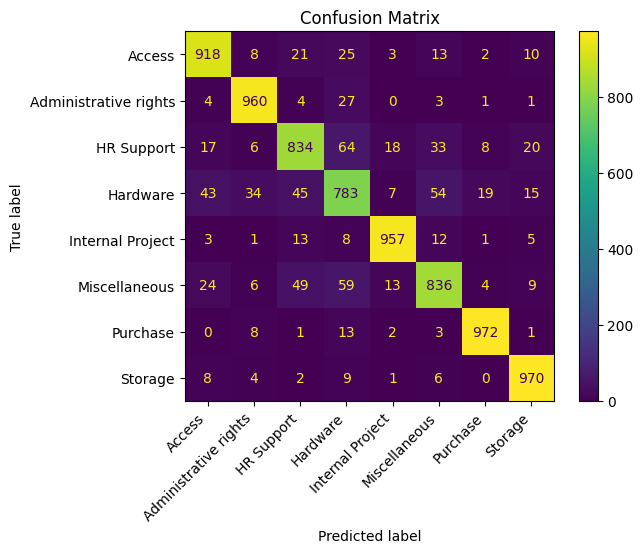

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay



# Creating ConfusionMatrixDisplay object and assign it to 'disp'
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=data["Topic_group"].astype('category').cat.categories)

# Plot confusion matrix using 'disp'
disp.plot(cmap='viridis', ax=plt.gca())
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for clarity
plt.title('Confusion Matrix')
plt.show()


** Training and Validation Accuracy and Loss Visualization**

Ploted the model's training and validation accuracy and loss over the training epochs. These plots helped to assess the model's performance, monitor overfitting, and understand how well the model is learning and generalizing as it trains

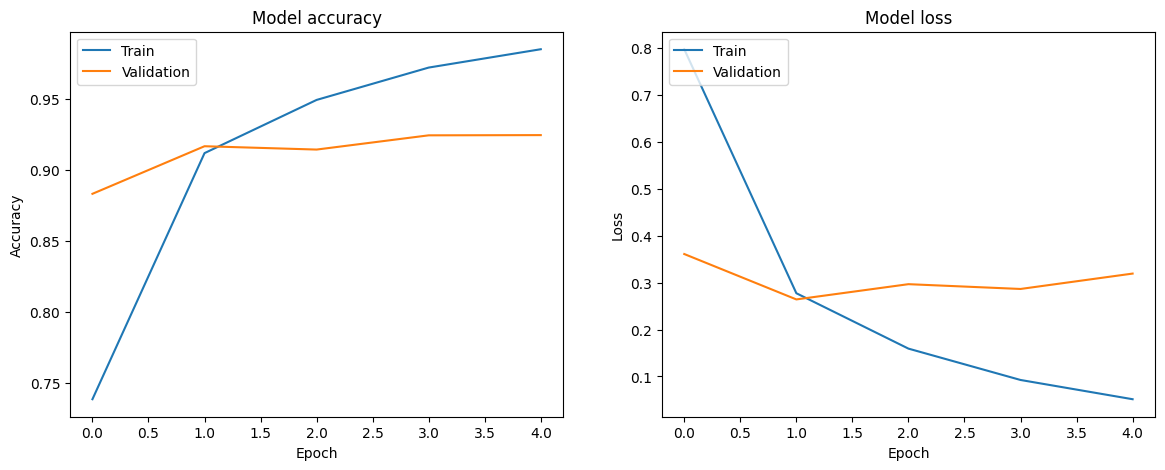

In [ ]:
# Plotting training & validation accuracy values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plotting training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Interactive window to test predictions

In [ ]:
# Mapping from numerical IDs to topic group names
id_to_topic = {
    0: "Access",
    1: "Administrative rights",
    2: "HR Support",
    3: "Hardware",
    4: "Internal Project",
    5: "Miscellaneous",
    6: "Purchase",
    7: "Storage"
}

# Prediction function
def predict_topic(text):
    # Tokenize and prepare the inputs
    encodings = tokenizer(text, return_tensors='tf', padding=True, truncation=True, max_length=128)
    # Predict
    outputs = model(encodings)
    logits = outputs.logits
    predicted_class_id = np.argmax(logits, axis=-1)[0]
    # Return the topic name from the mapping
    return id_to_topic.get(predicted_class_id, "Unknown Topic")

# Interactive prediction loop
while True:
    input_text = input("Enter text to predict the topic group (type 'exit' to quit): ")
    if input_text.lower() == 'exit':
        break
    prediction = predict_topic(input_text)
    print(f"Predicted topic group: {prediction}")

Enter text to predict the topic group (type 'exit' to quit): iam new to ,the project team,please add me
Predicted topic group: Miscellaneous
Enter text to predict the topic group (type 'exit' to quit): we are setting up a new project
Predicted topic group: Internal Project
Enter text to predict the topic group (type 'exit' to quit): our project needs new stationary please
Predicted topic group: Internal Project
Enter text to predict the topic group (type 'exit' to quit): iam an administrator for crm
Predicted topic group: Purchase
Enter text to predict the topic group (type 'exit' to quit): can you revoke her adminstrattive rights
Predicted topic group: Access
Enter text to predict the topic group (type 'exit' to quit): grant me permison to her email settings
Predicted topic group: Access
Enter text to predict the topic group (type 'exit' to quit): permision
Predicted topic group: Miscellaneous
Enter text to predict the topic group (type 'exit' to quit): administrator
Predicted topic g

KeyboardInterrupt: Interrupted by user